# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy.stats import linregress
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


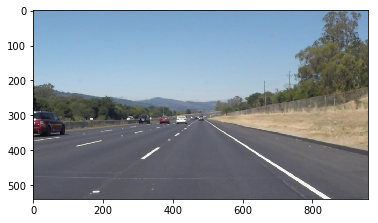

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#this is the original draw_lines function, paints non-continous marking when lane line is broken
def draw_lines(img, lines, thickness=2,color=[255, 0, 0], ):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if len(lines)==0:
        print("EMPTY Lines from Hough:")
        return 0
    #print("LINES SHAPE",np.shape(lines))
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return 1
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,thickness):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #print("SHAPE OF Hough Lines", lines.shape)
    #implement a check for lines is empty then break the flow

    ret_val=draw_lines(line_img, lines,thickness)
    if ret_val == 0:
        return 
    else:
        return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result i2age is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Now processing: solidWhiteCurve.jpg


C:\Users\atpandey\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\atpandey\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Now processing: solidWhiteRight.jpg
Now processing: solidYellowCurve.jpg
Now processing: solidYellowCurve2.jpg
Now processing: solidYellowLeft.jpg
Now processing: whiteCarLaneSwitch.jpg
['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


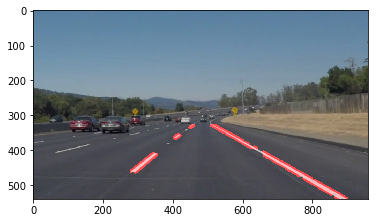

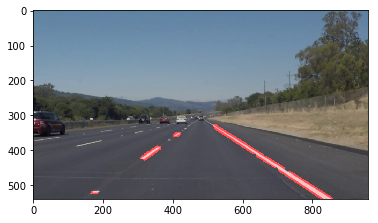

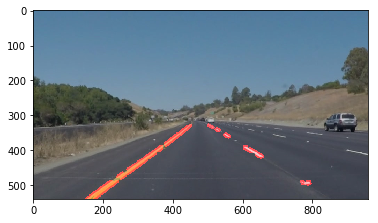

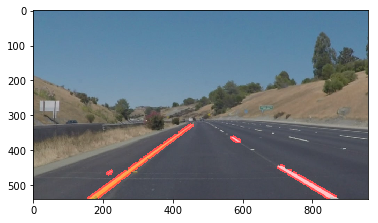

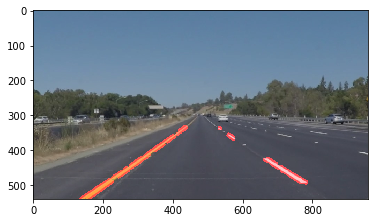

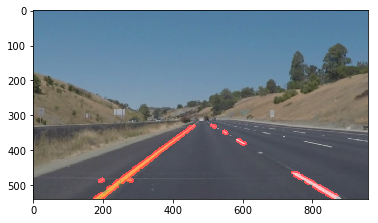

In [5]:
## Intitial pipeline without extrapolation of lane markings
#here is the steps in building pipeline function (called processing_steps here)
#function to add steps on images
#step1: load image ..> passed image after reading hence step1 is not needed in pipeline
#step2: convert to grey scale
#step3: gaussian blur
#step4: canny edge detenction
#step5: define vertices of polygon to mask
#step6: Hough transform (#step7: draw lines with a blank image --> already in deffor Hough transform)
#step8: overlap orig image with Hough trans and drawn_line img
def processing_steps(imname,kernel_size=5,low_threshold=50, high_threshold=150,rho=1,theta=np.pi/180,threshold=1,min_line_len=5,max_line_gap=1):
    #ld_image=load_image(imname)
    #ld_image=mpimg.imread(imname)
    grey_image=grayscale(imname)
    gaussian_image=gaussian_blur(grey_image, kernel_size)
    canny_image=canny(gaussian_image, low_threshold, high_threshold)
    
    # Here we are defining a four sided polygon to mask (trapeziodal shape)
    imshape = imname.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    #doesn't have to be a square
    #vertices = np.array([[(100,imshape[0]),(100,imshape[0]-300 ), (imshape[1]-100, imshape[0]-300), (imshape[1]-100,imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(100,imshape[0]),(450, 330), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    img_height = imname.shape[0]
    img_width = imname.shape[1]
    #vertices = np.array([[(50,imshape[0]),(450, 330), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(img_width/20,img_height),(0.45*img_width, 0.61*img_height), (0.54*img_width, 0.61*img_height), (imshape[1],imshape[0])]], dtype=np.int32)
    
    masked_image=region_of_interest(canny_image, vertices)
    
    hough_line_image=hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap,10)
    if hough_line_image == None:
        print("Hough lines were empty")
        return 
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((canny_image, canny_image, canny_image)) 
    f_image=weighted_img(hough_line_image,imname,  α=0.8, β=1., λ=0.)
    #return masked_image
    #return canny_image
    #return hough_line_image
    return f_image 


 
#test first img
im_list=os.listdir('test_images/')
im_files=[r'test_images/'+x for x in im_list]
#print(im_files)
#im_to_show=processing_steps(mpimg.imread(im_files[1]))
#plt.imshow(im_to_show)
#mpimg.imsave(r'test_images_output/'+im_list[1], im_to_show)
#
for imgs in im_list:
    print("Now processing:",imgs)
    im_to_show=processing_steps(mpimg.imread(r'test_images/'+imgs))
    if(im_to_show == None):
        print("Lane Marking failed")
    plt.figure()
    plt.imshow(im_to_show)
    mpimg.imsave(r'test_images_noninterpolated_output/'+imgs, im_to_show)
    
    #open cv channel BGR
    #cv2.imwrite(r'test_images_output/'+imgs, cv2.cvtColor(im_to_show, cv2.COLOR_RGB2BGR))
im_out_list=os.listdir('test_images_noninterpolated_output/')
print(im_out_list)

## updated draw_line function
** Although Improve draw_lines function is mentioned later in the notebook, it is implemented after first iteration to draw continous lane markings in pictures and videos, hence mentioned here**
** significant features **
1. for each point pair passed by Hough figure out slope (y2-y1)/(x2-x2)
2. bin the slopes to left lane if slope < 0 or to right lane if slope is > 0
3. the lines with slope 0 is ignored 
4. after few trials slope of -0.2 for left and 0.2 for right is chosen
5. assumption is there won't be such sharp turns from cars perspective, so ignore slopes in band -0.2 to 0.2
this helps in fitting co-eficients
6. store the x and y point pairs of left and right lanes
if line list is emtpy return empty

7. unroll x pints and y points and calcuate a fit for line (ployfit with order of 1), this gives slope and intercept
8. calculate lane points for bottom and top as
    1. bottom y point= image.shape[0]
    2. bottom x point =(bottom_y-intercept)/slope (y=mx+b)
    3. top y point is top point considered for perspective (default chosen as 350)
    4. top x point= (top_y-intercept/slope)

9. the points calculated as above are okay for picture but they flicker quite a bit for video,
10. when lane is moving (turning), the slope changes this induces flickering
11. implemented a rolling mean to smooteh flickering effect
choose average slope and intercept of last 20 slopes

In [6]:
#updated draw_line function
#significant features
# for each point pair passed by Hough figure out slope (y2-y1)/(x2-x2)
#bin the slopes to left lane if slope < 0 or to right lane if slope is > 0
#the lines with slope 0 is ignored 
#after few trials slope of -0.2 for left and 0.2 for right is chosen
#assumption is there won't be such sharp turns from cars perspective, so ignore slopes in band -0.2 to 0.2
#this helps in fitting co-eficients
# store the x and y point pairs of left and right lanes
#if line list is emtpy return empty

#unroll x pints and y points and calcuate a fit for line (ployfit with order of 1), this gives slope and intercept
#calculate lane points for bottom and top as
#bottom y point= image.shape[0]
#bottom x point =(bottom_y-intercept)/slope (y=mx+b)
#top y point is top point considered for perspective (default chosen as 350)
#top x point= (top_y-intercept/slope)

#the points calculated as above are okay for picture but they flicker quite a bit for video,
#when lane is moving (turning), the slope changes this induces flickering
#implemented a rolling mean to smooteh flickering effect
#choose average slope and intercept of last 20 slopes

def draw_lines(img, lines, thickness=2,color=[255, 0, 0],roll=20,y_top_l=350,y_top_r=350 ):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global left_lane_slope_global
    global left_lane_intercept_global 
    global right_lane_slope_global
    global right_lane_intercept_global 
    
    slopes_left=[]
    slopes_right=[]
    left_x1=[]
    left_x2=[]
    left_y1=[]
    left_y2=[]
    right_x1=[]
    right_x2=[]
    right_y1=[]
    right_y2=[]
    
    #if line coords pair are empty return null 
    if len(lines)==0:
        print("EMPTY Lines from Hough:")
        return 0
    
    #bin slope into left and right lane and store x,y pairs
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            #slope used as -0.2 and 0.2 to weed out slopes of 0 or less
            #assumption the perspective view of the vehicle wouldn't be so sharp
            #that slope is below 0.2, think it's reasonable
            if slope < -0.2:
                slopes_left.append(slope)
                left_x1.append(x1)
                left_x2.append(x2)
                left_y1.append(y1)
                left_y2.append(y2)
            elif slope > 0.2:
                slopes_right.append(slope)
                right_x1.append(x1)
                right_x2.append(x2)
                right_y1.append(y1)
                right_y2.append(y2)
    #find average of slope and atdev for left
    #only for comparison purpose with slope calculate from intercep
    left_avg_slopes=np.mean(slopes_left)
    left_stddev_slopes=np.std(slopes_left)
    #build x and y points for left unrolling x1 and x2 together and y1 and y2 together
    #make sure to capture y for corresponding x
    left_x=left_x1 + left_x2
    left_y=left_y1 + left_y2
    #print("len left_x:{} left_y:{} ".format(len(left_x),len(left_y)))

    #regression to find left slope and intercept
    left_m,left_b,r,p,err=linregress(left_x,left_y)
    #add to global list for rolling average, found issue in challenge video with empty left_m left_b, 
    #so check that not an empty values is added

    left_lane_slope_global.append(left_m)
    left_lane_intercept_global.append(left_b)
    
    
    #build x and y points for right unrolling x1 and x2 together and y1 and y2 together
    #make sure to capture y for corresponding x
    right_x=right_x1 + right_x2
    right_y=right_y1 + right_y2
    #print("lright_x:{} right_y:{}".format(len(right_x),len(right_y)))
    #regression to find right slope and intercept
    right_m,right_b,r,p,err=linregress(right_x,right_y)
    #add to global list for rolling average

    right_lane_slope_global.append(right_m)
    right_lane_intercept_global.append(right_b)

            
    #find average of slope and stdev for right
    #only for comparison purpose with slope calculate from intercep
    right_stddev_slopes=np.std(slopes_right)        
    right_avg_slopes=np.mean(slopes_right)

    #rolling average of slope and intercept for left
    #if elements in global list > roll (default=20)
    #the sloe to use is the average of last roll time of slope
    #else use current slope 
    #assumption that first roll frame will have consistent slopes/intercept
    #i.e. vehicles is not turning sharply at start
    
    imshape=img.shape
    
    left_m_avg=0.0
    left_b_avg=0.0
    if(len(left_lane_slope_global) > roll):
        left_m_avg=np.mean(left_lane_slope_global[-roll:])
        left_b_avg=np.mean(left_lane_intercept_global[-roll:])
    else:
        left_m_avg=left_m
        left_b_avg=left_b
    #find x and y for left lane
    left_first_y=img.shape[0]
    left_first_x=int((left_first_y-left_b_avg)/left_m_avg)
    left_last_x=int((y_top_l-left_b_avg)/left_m_avg)
    
    
    #rolling avg of slope and intercept
    right_m_avg=0.0
    right_b_avg=0.0
    if(len(right_lane_slope_global)>roll):
        right_m_avg=np.mean(right_lane_slope_global[-roll:])
        right_b_avg=np.mean(right_lane_intercept_global[-roll:])
    else:
        right_m_avg=right_m
        right_b_avg=right_b
    #find x and y for right lane
    right_first_y=img.shape[0]    
    right_first_x=int((right_first_y-right_b_avg)/right_m_avg)    
    right_last_x=int((y_top_r-right_b_avg)/right_m_avg)
    ##draw the lines
    cv2.line(img, (left_first_x, left_first_y), (left_last_x, y_top_l), color, thickness)
    cv2.line(img, (right_first_x, right_first_y), (right_last_x, y_top_r), color, thickness)
    
    #return 1 success
    return 1
    

Now processing: solidWhiteCurve.jpg


C:\Users\atpandey\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\atpandey\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:67: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Now processing: solidWhiteRight.jpg
Now processing: solidYellowCurve.jpg
Now processing: solidYellowCurve2.jpg
Now processing: solidYellowLeft.jpg
Now processing: whiteCarLaneSwitch.jpg
['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'test.jpg', 'whiteCarLaneSwitch.jpg']


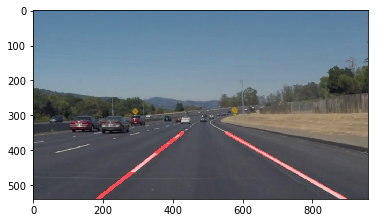

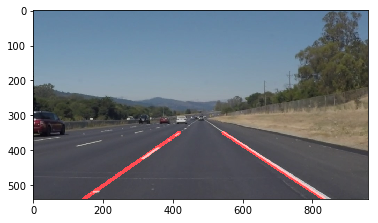

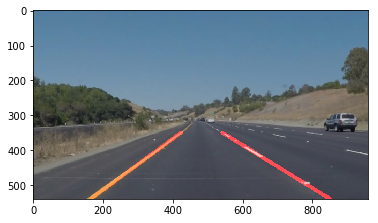

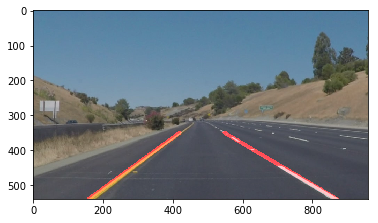

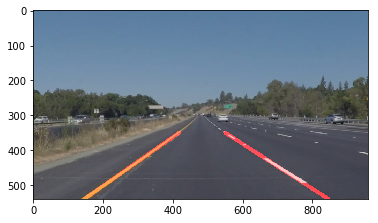

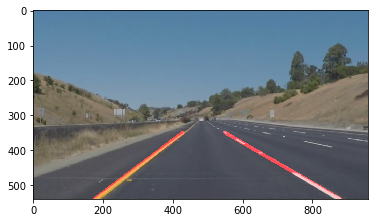

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


#here is the steps in building pipeline function (called processing_steps here)
#function to add steps on images
#step1: load image ..> passed image after reading hence step1 is not needed in pipeline
#step2: convert to grey scale
#step3: gaussian blur
#step4: canny edge detenction
#step5: define vertices of polygon to mask
#step6: Hough transform (#step7: draw lines with a blank image --> already in deffor Hough transform)
#step8: overlap orig image with Hough trans and drawn_line img
def processing_steps(imname,kernel_size=5,low_threshold=50, high_threshold=150,rho=1,theta=np.pi/180,threshold=1,min_line_len=5,max_line_gap=1):
    #ld_image=load_image(imname)
    #ld_image=mpimg.imread(imname)
    grey_image=grayscale(imname)
    gaussian_image=gaussian_blur(grey_image, kernel_size)
    canny_image=canny(gaussian_image, low_threshold, high_threshold)
    
    # Here we are defining a four sided polygon to mask (trapeziodal shape)
    imshape = imname.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    #doesn't have to be a square
    #vertices = np.array([[(100,imshape[0]),(100,imshape[0]-300 ), (imshape[1]-100, imshape[0]-300), (imshape[1]-100,imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(100,imshape[0]),(450, 330), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    img_height = imname.shape[0]
    img_width = imname.shape[1]
    #vertices = np.array([[(50,imshape[0]),(450, 330), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(img_width/20,img_height),(0.45*img_width, 0.6*img_height), (0.54*img_width, 0.6*img_height), (imshape[1],imshape[0])]], dtype=np.int32)
    
    masked_image=region_of_interest(canny_image, vertices)
    
    hough_line_image=hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap,10)
    if hough_line_image == None:
        print("Hough lines were empty")
        return 
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((canny_image, canny_image, canny_image)) 
    f_image=weighted_img(hough_line_image,imname,  α=0.8, β=1., λ=0.)
    #return masked_image
    #return canny_image
    #return hough_line_image
    return f_image 


#maintain a running average of 20 frames
#Maintaining a running average of the past N frames is a good idea for videos of pics with lanes having 
#both pos and negative slopes as in sharp turns

left_lane_slope_global=[]
left_lane_intercept_global=[] 
right_lane_slope_global=[]
right_lane_intercept_global=[] 
#test first img
im_list=os.listdir('test_images/')
im_files=[r'test_images/'+x for x in im_list]
#print(im_files)
#im_to_show=processing_steps(mpimg.imread(im_files[1]))
#plt.imshow(im_to_show)
#mpimg.imsave(r'test_images_output/'+im_list[1], im_to_show)
#
for imgs in im_list:
    print("Now processing:",imgs)
    im_to_show=processing_steps(mpimg.imread(r'test_images/'+imgs))
    if(im_to_show == None):
        print("Lane Marking failed")
    plt.figure()
    plt.imshow(im_to_show)
    mpimg.imsave(r'test_images_output/'+imgs, im_to_show)
    
    #open cv channel BGR
    #cv2.imwrite(r'test_images_output/'+imgs, cv2.cvtColor(im_to_show, cv2.COLOR_RGB2BGR))
im_out_list=os.listdir('test_images_output/')
print(im_out_list)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result=processing_steps(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [10]:


#global vars to implement rolling mean of slope and intercept to avoid flickers in videos when slope of lane diverges (turns)
left_lane_slope_global=[]
left_lane_intercept_global=[] 
right_lane_slope_global=[]
right_lane_intercept_global=[]


white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#clip1.ipython_display()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 29.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
#global vars to implement rolling mean of slope and intercept to avoid flickers in videos when slope of lane diverges (turns)
left_lane_slope_global=[]
left_lane_intercept_global=[] 
right_lane_slope_global=[]
right_lane_intercept_global=[]

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:24<00:00, 24.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 25.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## The challenge video has different perspective than rest of the other picture and videos
1. this video also has shadows and divider close to lane marking
2. a mask is implemented which picks only yellow and white pixels from the picture
3. cvtcolor changes RGB is to HSV (couldn't figure appropriate mask for RGB)
    1. a yellow mask is applied first
    2. sensitivity = 25
    3. upper_yellow = np.array([100, 255, 255]) 
    4. lower_yellow = np.array([80, 100, 100])
    5. mask_y = cv2.inRange(hsv, lower_yellow, upper_yellow)   
    6. res_y = cv2.bitwise_and(hsv,hsv, mask= mask_y)
    7. then a white mask
    8. lower_white = np.array([0,0,255-sensitivity])
    9. upper_white = np.array([255,sensitivity,255])
    10. mask_w = cv2.inRange(hsv, lower_white, upper_white)
    11. res_w = cv2.bitwise_and(hsv,hsv, mask= mask_w)
    12. then merge the two mask images
    13. mask_f=cv2.bitwise_or(res_y,res_w)
4. for perspective the region of interest mask is adjusted and top positions for lane marking is moved to lower coords
5. applying white and yellow mask in my opinion is better than greyscaling

** *First few frames show flickering lane marks but gets better after rolling average kicks in **

** *Car's hood comes in view at later part, lane marking overlaps with hood**

In [14]:
#The challenge video has different perspective than rest of the other picture and videos
#this video also has shadows and divider close to lane marking
#a mask is implemented which picks only yellow and white pixels from the picture
#cvtcolor changes RGB is to HSV (couldn't figure appropriate mask for RGB)
# a yellow mask is applied first
#sensitivity = 25
#upper_yellow = np.array([100, 255, 255]) 
#lower_yellow = np.array([80, 100, 100])
#mask_y = cv2.inRange(hsv, lower_yellow, upper_yellow)   
#res_y = cv2.bitwise_and(hsv,hsv, mask= mask_y)

#then a white mask
#lower_white = np.array([0,0,255-sensitivity])
#upper_white = np.array([255,sensitivity,255])
#mask_w = cv2.inRange(hsv, lower_white, upper_white)
#res_w = cv2.bitwise_and(hsv,hsv, mask= mask_w)
#then merge the two mask images
#mask_f=cv2.bitwise_or(res_y,res_w)
#for perspective the region of interest mask is adjusted and top positions for lane marking is moved to lower coords






#restrict y_top_l y_top_r to lower than normal as perspective in challenge video is not the same as others
#this function can be in the other section where other helper functions are, only addition is check if len(left_x) or len(left_y) ==0
#or len(right_x) or len(right_y) ==0 skip drawing line
#y_top_l and y_topr can be adjusted while calling hough
def draw_lines(img, lines, thickness=2,color=[255, 0, 0],roll=20,y_top_l=480,y_top_r=460 ):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global left_lane_slope_global
    global left_lane_intercept_global 
    global right_lane_slope_global
    global right_lane_intercept_global 
    
    slopes_left=[]
    slopes_right=[]
    left_x1=[]
    left_x2=[]
    left_y1=[]
    left_y2=[]
    right_x1=[]
    right_x2=[]
    right_y1=[]
    right_y2=[]
    
    if len(lines)==0:
        print("EMPTY Lines from Hough:")
        return
    #print("LINES LEN",len(lines))    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            #slope used as -0.2 and 0.2 to weed out slopes of 0 or less
            #assumption the perspective view of the vehicle wouldn't be so sharp
            #that slope is below 0.2, think it's reasonable
            if slope < -0.3:
                slopes_left.append(slope)
                #print("slope left",slope)
                left_x1.append(x1)
                left_x2.append(x2)
                left_y1.append(y1)
                left_y2.append(y2)
            elif slope > 0.3:
                slopes_right.append(slope)
                #print("slope right",slope)
                right_x1.append(x1)
                right_x2.append(x2)
                right_y1.append(y1)
                right_y2.append(y2)
    #find average of slope and atdev for left
    #only for comparison purpose with slope calculate from intercep
    left_avg_slopes=np.mean(slopes_left)
    left_stddev_slopes=np.std(slopes_left)
    #build x and y points for left unrolling x1 and x2 together and y1 and y2 together
    #make sure to capture y for corresponding x
    left_x=left_x1 + left_x2
    left_y=left_y1 + left_y2
    #print("len left_x:{} left_y:{} ".format(len(left_x),len(left_y)))
    if (len(left_x) ==0 or len(left_y) ==0):
        print ( "left slope x and y empty, draw lines has a problem")
        return
    #regression to find left slope and intercept
    left_m,left_b,r,p,err=linregress(left_x,left_y)
    #add to global list for rolling average, found issue in challenge video with empty left_m left_b, 
    #so check that not an empty values is added

    left_lane_slope_global.append(left_m)
    left_lane_intercept_global.append(left_b)
    
    
    #build x and y points for right unrolling x1 and x2 together and y1 and y2 together
    #make sure to capture y for corresponding x
    right_x=right_x1 + right_x2
    right_y=right_y1 + right_y2
    
    #print("right_x:{} right_y:{}".format(len(right_x),len(right_y)))
    if (len(right_x) ==0 or len(right_y)==0):
        print ( "right slope x and y empty, draw lines has a problem")
        return
    #regression to find right slope and intercept
    right_m,right_b,r,p,err=linregress(right_x,right_y)
    #add to global list for rolling average

    right_lane_slope_global.append(right_m)
    right_lane_intercept_global.append(right_b)

            
    #find average of slope and atdev for right
    #only for comparison purpose with slope calculate from intercep
    right_stddev_slopes=np.std(slopes_right)        
    right_avg_slopes=np.mean(slopes_right)

    #rolling average of slope and intercept for left
    #if elements in global list > roll (default=20)
    #the sloe to use is the average of last roll time of slope
    #else use current slope 
    #assumption that first roll frame will have consistent slopes/intercept
    #i.e. vehicles is not turning sharply at start
    imshape=img.shape
    left_m_avg=0.0
    left_b_avg=0.0
    if(len(left_lane_slope_global) > roll):
        left_m_avg=np.mean(left_lane_slope_global[-roll:])
        left_b_avg=np.mean(left_lane_intercept_global[-roll:])
    else:
        left_m_avg=left_m
        left_b_avg=left_b
    #find x and y for left lane
    left_first_y=img.shape[0]
    left_first_x=int((left_first_y-left_b_avg)/left_m_avg)
    left_last_x=int((y_top_l-left_b_avg)/left_m_avg)
    
    
    #rolling avg of slope and intercept
    right_m_avg=0.0
    right_b_avg=0.0
    if(len(right_lane_slope_global)>roll):
        right_m_avg=np.mean(right_lane_slope_global[-roll:])
        right_b_avg=np.mean(right_lane_intercept_global[-roll:])
    else:
        right_m_avg=right_m
        right_b_avg=right_b
    #find x and y for left lane
    right_first_y=img.shape[0]    
    right_first_x=int((right_first_y-right_b_avg)/right_m_avg)    
    right_last_x=int((y_top_r-right_b_avg)/right_m_avg)
    ##draw the lines
    cv2.line(img, (left_first_x, left_first_y), (left_last_x, y_top_l), color, thickness)
    cv2.line(img, (right_first_x, right_first_y), (right_last_x, y_top_r), color, thickness)
    return 1

def mask_yellow_and_white_image(imname):
    hsv = cv2.cvtColor(imname, cv2.COLOR_BGR2HSV)
    # define range of yellow color in HSV
    sensitivity = 25
    upper_yellow = np.array([100, 255, 255]) 
    lower_yellow = np.array([80, 100, 100]) 

    # Threshold the HSV image to get only yellow colors
    mask_y = cv2.inRange(hsv, lower_yellow, upper_yellow)   
    #plt.imshow(mask_y)

    res_y = cv2.bitwise_and(hsv,hsv, mask= mask_y)
    #plt.imshow(res_y)


    
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
 
    mask_w = cv2.inRange(hsv, lower_white, upper_white)
    res_w = cv2.bitwise_and(hsv,hsv, mask= mask_w)
    #plt.imshow(res_w)

    mask_f=cv2.bitwise_or(res_y,res_w)
    #plt.imshow(mask_f)
    return mask_f


def processing_steps(imname,kernel_size=5,low_threshold=50, high_threshold=100,rho=1,theta=np.pi/180,threshold=1,min_line_len=5,max_line_gap=1):
    #ld_image=load_image(imname)
    #ld_image=mpimg.imread(imname)
    #grey_image=grayscale(masked_w)
    #gaussian_image=gaussian_blur(grey_image, kernel_size)
           
    mask_f=mask_yellow_and_white_image(imname)
    gaussian_image=gaussian_blur(mask_f, kernel_size)
    
    canny_image=canny(gaussian_image, low_threshold, high_threshold)
    
    # This time we are defining a four sided polygon to mask
    imshape = imname.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    #doesn't have to be a square
    #vertices = np.array([[(100,imshape[0]),(100,imshape[0]-300 ), (imshape[1]-100, imshape[0]-300), (imshape[1]-100,imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(100,imshape[0]),(450, 330), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    img_height = imname.shape[0]
    img_width = imname.shape[1]
    #vertices = np.array([[(50,imshape[0]),(450, 330), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(50,img_height-30),(450, 375), (510, 400), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    vertices = np.array([[(img_width/20+40,img_height),(0.45*img_width-40, 0.5*img_height), (0.54*img_width+40, 0.5*img_height), (imshape[1],imshape[0])]], dtype=np.int32)
    
    masked_image=region_of_interest(canny_image, vertices)
    
    hough_line_image=hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap,10)
    #if hough_line_image==None:
    #    print(" Hough lines empty")
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((canny_image, canny_image, canny_image)) 
    f_image=weighted_img(hough_line_image,imname,  α=0.8, β=1., λ=0.)
    #return masked_image
    #return canny_image
    #return hough_line_image
    return f_image 



In [15]:
#global vars to implement rolling mean of slope and intercept to avoid flickers in videos when slope of lane diverges (turns)
left_lane_slope_global=[]
left_lane_intercept_global=[] 
right_lane_slope_global=[]
right_lane_intercept_global=[]




challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 54%|█████████████████████▌                  | 135/251 [00:10<00:11, 10.34it/s]

right slope x and y empty, draw lines has a problem


100%|████████████████████████████████████████| 251/251 [00:22<00:00, 11.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 24 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))